# 필요한 패키지 다운로드

In [1]:
!pip install mxnet
!pip install gluonnlp tqdm
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 47.3 MB 1.5 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 25.4 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595723 sha256=52955ff9eab6fb2a0acc032447e0a43309a4e63f90c8ef695905a0bebec56a4b
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 26.8 MB/s 
     |████████████████████████████████| 3.8 MB 28.5 MB/s 
     |████████████████████████████████| 6.5 MB 50.5 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 71.7 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.

In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-eaz9nhu_
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-eaz9nhu_
     |████████████████████████████████| 132 kB 30.4 MB/s 
     |████████████████████████████████| 4.5 MB 51.9 MB/s 
     |████████████████████████████████| 8.6 MB 60.3 MB/s 
     |████████████████████████████████| 79 kB 9.2 MB/s 
     |████████████████████████████████| 127 kB 54.4 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=8d8fb08c07c24718f6258fadc9fbe174937ccc06fd4ce13ef9b95805875cbc09
  Stored in directory: /tmp/pip-ephem-wheel-cache-_a8uvdgv/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does no

In [3]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:37tcmalloc: large alloc 1147494400 bytes == 0x5597d02ee000 @  0x7fbe80d16615 0x5597978253bc 0x55979790618a 0x5597978281cd 0x55979791ab3d 0x55979789c458 0x55979789702f 0x559797829aba 0x55979789c2c0 0x55979789702f 0x559797829aba 0x559797898cd4 0x55979791b986 0x559797898350 0x55979791b986 0x559797898350 0x55979791b986 0x559797898350 0x559797829f19 0x55979786da79 0x559797828b32 0x55979789c1dd 0x55979789702f 0x559797829aba 0x559797898cd4 0x55979789702f 0x559797829aba 0x559797897eae 0x5597978299da 0x559797898108 0x55979789702f
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:12:16tcmalloc: large alloc 1434370048 bytes == 0x559814944000 @  0x7fbe80d16615 0x5597978253bc 0x55979790618a 0x5597978281cd 0x55979791ab3d 0x55979789c458 0x55979789702f 0x559797829aba 0x55979789c2c0 0x55979789702f 0x559797829aba 0x559797898cd4 0x55979791b986 0x5597978983

# 데이터 불러오기

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [5]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [6]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
device = torch.device("cuda")
# device = torch.device("cpu")

In [9]:
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


## 데이터 전처리

In [10]:
dataset_train = []
dataset_test = []

root = "/content/drive/MyDrive/news_class9x1400/"
list = os.listdir(root)
categories = {category:i for i,category in enumerate(list)}

for cat in categories:
    # 폴더 안에 들어있는 파일들 불러오기
    files = os.listdir(root + cat)

    # 텍스트 파일을 리스트로 만들기
    for i,f in enumerate(files):
        fname = root + cat + "/" + f
        file = open(fname, "r", encoding="utf-8")
        strings = file.read()
        # train dataset은 카테고리당 1120개(80%)까지
        if i<1120:
            dataset_train.append([strings, categories[cat]])
        else:
            dataset_test.append([strings,categories[cat]])
        file.close()

print(len(dataset_train), len(dataset_test))
    

10080 2520


In [11]:
# 카테고리 확인
categories

{'ITscience': 0,
 'culture': 5,
 'economy': 1,
 'entertainment': 6,
 'health': 2,
 'life': 7,
 'politic': 8,
 'social': 3,
 'sport': 4}

In [12]:
length = [len(dataset_train[i][0]) for i in range(len(dataset_train))]
length_avg = sum(length) / len(length)

print(f'뉴스 기사의 최대 길이: {max(length)}')
print(f'뉴스 기사의 평균 길이: {int(length_avg)}')

뉴스 기사의 최대 길이: 4736
뉴스 기사의 평균 길이: 2386


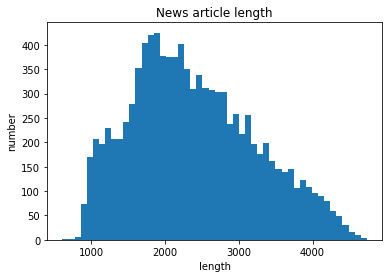

In [13]:
plt.hist(length, bins = 50)
plt.xlabel('length')
plt.ylabel('number')
plt.title('News article length')
plt.show();

In [14]:
# vocab을 활용해 tokenizer 선언
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


# 데이터셋 클래스 선언

In [15]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [16]:
l1 = [len(i[0]) for i in dataset_train]
l2 = [len(i[0]) for i in dataset_test]
max(max(l1),max(l2))

4911

In [17]:
## Setting parameters
max_len = 128
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  0.00001

In [18]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [19]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 모델 만들기

In [20]:
# BERT-base model fine-tuning
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=9,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        #valid_length 까지만 1, 나머지는 0으로 mask를 생성
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        # return_dict=False 추가
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        #pooler는 CLS토큰에 대한 임베딩의 결과, 단순히 첫번째 토큰에 대한 결과가 아니라 문맥을 알아내기 위한 추가 layer를 통과한다.(아마도?)
        #임베딩의 결과에 linear layer를 통과시켜서 classification을 진행한다.
        # print(pooler.shape) batchsize * 768

        #_는 64개(max_length)의 모든 토큰에 대한 임베딩의 결과
        #단어 임베딩을 알고 싶을 때 사용할 수 있다.
        #_의 첫번째 값과 pooler와는 다른 값을 가지고 있는데 pooler는 _의 첫번째 값의 추가적으로 한번더 과정을 거친다.
        #print(_.shape) batchsize * max_len * 768

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out) #batchsize * num_classes

In [21]:
# 모델 선언
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [22]:
# optimizer

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [23]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# 손실함수 선언
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [25]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [26]:
# 정확도 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 모델 훈련

1. learning_rate = 5e-5, max_len = 64, batch_size = 64

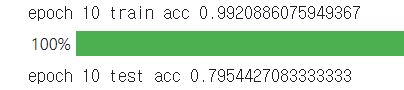

2. learning_rate = 5e-5, max_len = 64, batch_size = 32

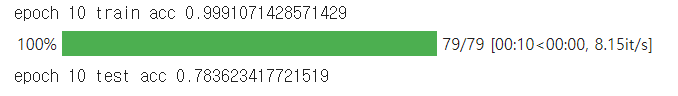

3. learning_rate = 5e-5, max_len = 128, batch_size = 32
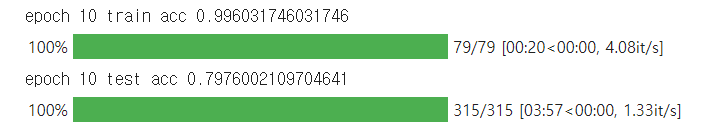



4. learning_rate = 5e-5, max_len = 128, batch_size = 16

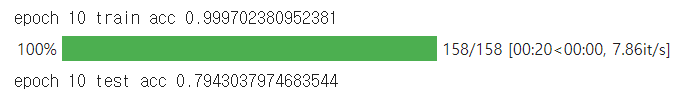

5. learning_rate = 0.0001, max_len = 128, batch_size = 16
(epoch 6 이후로는 train acc만 오르고 test acc는 떨어짐)

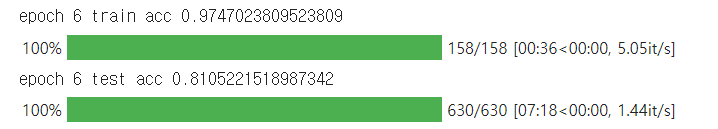

6. learning_rate = 0.0001, max_len = 128, batch_size = 32 (epoch 6 이후로 train acc 만 오르고 test acc는 떨어짐)

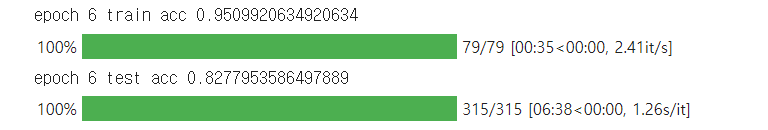

In [27]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        # if batch_id % log_interval == 0:
        #     print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/315 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 train acc 0.3257936507936508


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 1 test acc 0.729957805907173


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 2 train acc 0.7952380952380952


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 2 test acc 0.8027426160337553


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 3 train acc 0.8584325396825396


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 3 test acc 0.8094672995780591


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 4 train acc 0.8992063492063492


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 4 test acc 0.8304324894514769


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 5 train acc 0.9245039682539683


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 5 test acc 0.8223892405063291


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 6 train acc 0.9466269841269841


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 6 test acc 0.820675105485232


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 7 train acc 0.9596230158730159


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 7 test acc 0.8242352320675105


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 8 train acc 0.9686507936507937


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 8 test acc 0.8221255274261604


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 9 train acc 0.971031746031746


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 9 test acc 0.8218618143459915


  0%|          | 0/315 [00:00<?, ?it/s]

epoch 10 train acc 0.9742063492063492


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 10 test acc 0.8225210970464135


## 모델 Test

In [28]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

In [29]:
torch.save(model.state_dict(), "news.pt")
modelload = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
modelload.load_state_dict(torch.load("news.pt", device))
# modelload.eval()

<All keys matched successfully>

In [30]:
def testModel(model, seq):
    cate = dict(map(reversed,categories.items()))
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    modelload.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()
    print("뉴스의 카테고리는:", cate[idx])
    print("신뢰도는:", "{:.2f}%".format(softmax(result,idx)))

In [31]:
testModel(model, "울진국민체육센터에서 이재민 생활을 하고 있는 이들은 대부분 70~80대의 고령으로 이번 산불로 집이 전소되거나 화재에 놀라 황급히 집을 떠나는 바람에 입고 있던 옷차림으로 탈출했다. 이재민 100여 명은 지난 4일부터 닷새째 쪽잠을 자며 대피소 생활을 해왔지만 이날부터는 냉기를 피해 잠을 잘 수 있게 됐다. 이들은 이날 덕구온천호텔로 옮겨 당분간 생활한다. 경북도는 이재민 거주시설이 마련될 때까지 호텔 등 숙박시설에서 생활할 수 있도록 대책을 마련했다. 이재민 중 103명은 덕구온천호텔로 옮겼으며 14명은 각 마을회관, 39명은 국민체육센터에서 계속 거주하기를 희망했다. 나머지 이재민들은 친인척 집 등으로 몸을 옮겼다. 울진국민체육센터에 잔류한 이재민들은 자신의 논·밭에서 멀리 떨어지지 않는 곳에 대피소 설치를 요구했다.")

뉴스의 카테고리는: social
신뢰도는: 97.34%


In [32]:
testModel(model, "넥슨의 상반기 최고 기대작 '던전앤파이터 모바일'의 출시가 초읽기에 들어간 가운데 '던파 모바일'의 멀티버스 세계관을 암시하는 영상이 공개돼 큰 관심을 모으고 있다.\n넥슨이 '던파 모바일'의 애니메이션과 실제 플레이 영상을 공식 유튜브에 올리자 수백 명의 이용자가 멀티버스 세계관을 추측하는 등 관심을 쏟아내고 있다.")

뉴스의 카테고리는: ITscience
신뢰도는: 97.96%


In [33]:
testModel(model, "윤 당선인은 이날 오후 서울 여의도 국회의장실을 찾아 '국회에서 하는 일, 행정부에서 하는 일 따로 있다고 생각 안 할 것'이라며 '늘 국정의 중심에 의회가 있다는 생각을 갖고, 늘 상의하고 함께 머리를 맞대 고민하면 어떠한 어려운 국가적 난제라도 국민들께서 다 이해하고 잘 풀어나갈 수 있을 것'이라고 밝혔다.\n이에 박 의장은 '다시 한 번 축하드리고, 통합과 번영을 말씀해주셨는데 시대적 소명 잘 이루시라'고 덕담을 건넸다.")

뉴스의 카테고리는: politic
신뢰도는: 98.22%


In [34]:
testModel(model, "생활고에 시달리다 발달장애 자녀를 살해한 친모들이 검찰에 송치됐다.\n경기 수원중부경찰서는 살인 혐의로 구속한 40대 여성 A씨를 11일 검찰에 송치했다. 시흥경찰서도 같은 혐의로 구속한 B(54·여) 씨를 이날 송치했다.\nA씨는 지난 2일 오전 수원시 장안구 조원동 자택에서 발달장애인 아들 C(8) 군을 질식시켜 숨지게 한 혐의를 받고 있다.")

뉴스의 카테고리는: social
신뢰도는: 97.63%


In [35]:
testModel(model, "코스피 시총 2위의 LG에너지솔루션이 상장 이후 처음으로 주가가 40만원 아래로 밀렸다. 코스피200 지수 편입으로 공매도 제한이 풀리면서 주가가 4%대 약세를 보이고 있다.\n11일 오전 9시 30분 현재 LG에너지솔루션은 전일 대비 1만8000원(4.31%) 내린 39만9500원에 거래되고 있다.\nLG에너지솔루션은 이날 장초반 39만9000원까지 하락해 지난 8일 40만2500원을 깨고 상장 이후 최저가를 경신했다.")

뉴스의 카테고리는: economy
신뢰도는: 97.08%


In [36]:
testModel(model, "소설가 박상영(34)·정보라(46)가 세계 3대 문학상 중 하나로 꼽히는 부커상 인터내셔널 부문(The International Booker Prize) 후보에 함께 올랐다. 한국 작가가 이 부문 후보에 동시 지명된 것은 이번이 처음이다.\n영국 부커상 재단은 10일(이하 현지시간) 공식 홈페이지를 통해 박상영의 <대도시의 사랑법>(Love in the Big City)과 정보라의 <저주토끼>(Cursed Bunny)를 포함한 2022년 부커상 인터내셔널 부문 1차 후보(롱리스트) 13편을 발표했다. 2018년 부커상 인터내셔널 부문과 노벨문학상을 수상한 작가 올가 토카르추크의 <야곱의 책들>(The Books of Jacob) 등이 후보작에 함께 올렸다.")

뉴스의 카테고리는: culture
신뢰도는: 97.88%


In [37]:
testModel(model, "경기남부 지역은 낮 15도 내외 따뜻한 봄 날씨가 예상된다.\n수도권기상청에 따르면 이날 낮 기온은 따뜻한 남서풍과 일사에 의해 대폭 오를 것으로 보인다.\n아침 최저기온은 수원 2도 등 영하 2~4도, 낮 최고기온은 수원 17도 등 14~19도로 예보됐다.")

뉴스의 카테고리는: social
신뢰도는: 91.91%


In [38]:
testModel(model, "삼성전자는 이날 오후 갤럭시S22 시리즈 3종을 대상으로 소프트웨어 업데이트를 진행했다. 게임 실행 시 중앙처리장치(CPU)와 그래픽처리장치(GPU)의 성능제한을 해제하고 GOS를 끌 수 있는 외부 앱 차단을 해제하는 것이 이번 업데이트 내용이다.")

뉴스의 카테고리는: ITscience
신뢰도는: 98.34%


In [39]:
testModel(model, "한국과 미국 정보당국이 북한의 최근 두 차례 탄도미사일 시험발사를 신형 대륙간탄도미사일(ICBM)로 규정했다. 북한이 사실상 모라토리엄(핵실험 및 ICBM 시험발사 유예)을 폐기한 것으로 판단했다는 점에서 추가 제재가 불가피하게 됐다. 차기 정부 출범을 앞두고 한반도 정세 긴장이 다시 고조될 전망이다.")

뉴스의 카테고리는: social
신뢰도는: 96.83%


In [40]:
testModel(model, "방탄소년단이 2019년 10월 이곳에서 열었던 월드 투어 공연 이후 864일, 약 2년 반 만에 성사된 대면 공연이었습니다.\n이 공연은 코로나 이후 최대 규모로 관객 1만 5천 명이 2시간 반 동안 다채로운 무대를 즐겼습니다.")

뉴스의 카테고리는: culture
신뢰도는: 97.71%


In [41]:
testModel(model, "'페이커'는 솔로 랭크의 사고에 관해선 말을 아끼던 선수였다. 오랫동안 2013년부터 프로게이머로 활동하면서 여러 사건-사고를 경험했지만, 웬만한 일에 흔들리지 않았다. 그런데 이번 만큼은 '한 판만 더 저런 애들을 만나면 솔로 랭크를 더 하지 않겠다'며 강한 발언을 했다.")

뉴스의 카테고리는: ITscience
신뢰도는: 65.66%


In [42]:
testModel(model, "현재 서울의 초미세먼지 농도는 44 마이크로그램 등 노란 색으로 보이는 중부와 전북, 영남 지역에선 초미세먼지 농도 나쁨 단계를 나타내고 있습니다.\n오후에도 수도권과 영서, 충청과 전북 경북에선 미세먼지 농도 나쁨 단계가 이어지겠습니다.")

뉴스의 카테고리는: social
신뢰도는: 84.13%
